In [62]:
!pip install tensorflow numpy scikit-learn Pillow

In [109]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from google.colab import files
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from IPython.display import Image

In [81]:
deforestation_dir = "/content/dataset/deforestation"
no_deforestation_dir = "/content/dataset/no_deforestation"

images = []
labels = []

In [82]:
for filename in os.listdir(deforestation_dir):
    img_path = os.path.join(deforestation_dir, filename)
    try:
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(1)
    except Exception as e:
        print(f"Error loading image {filename}: {e}")

In [83]:
for filename in os.listdir(no_deforestation_dir):
    img_path = os.path.join(no_deforestation_dir, filename)
    try:
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(0)
    except Exception as e:
        print(f"Error loading image {filename}: {e}")

In [84]:
images = np.array(images)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [85]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [86]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

In [87]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [88]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [89]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))


In [90]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping],
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.5127 - loss: 1.1867 - val_accuracy: 0.3158 - val_loss: 0.8843
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - accuracy: 0.3916 - loss: 1.1976 - val_accuracy: 0.6842 - val_loss: 0.5666
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - accuracy: 0.5418 - loss: 0.7200 - val_accuracy: 0.7895 - val_loss: 0.5586
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - accuracy: 0.6469 - loss: 0.6501 - val_accuracy: 0.8947 - val_loss: 0.5301
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.7629 - loss: 0.5884 - val_accuracy: 0.8947 - val_loss: 0.3866
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.7311 - loss: 0.7222 - val_accuracy: 0.8947 - val_loss: 0.4355
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.7987 - loss: 0.5313 - val_accuracy: 0.5263 - val_loss: 0.6564
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6990 - loss: 0.5307 - val_accuracy: 0.7895 - val_loss: 0.3772
Epoch 9/

In [91]:
model.save("/content/deforestation_model.h5")

In [92]:
def predict_and_store(image_path):
    try:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        prediction = model.predict(img_array)

        if prediction[0][0] >= 0.5:
            prediction_label = "Deforested"
            destination_folder = "/content/deforested_images"
        else:
            prediction_label = "Not Deforested"
            destination_folder = "/content/no_deforested_images"

        os.makedirs(destination_folder, exist_ok=True)

        filename = os.path.basename(image_path)

        destination_path = os.path.join(destination_folder, filename)

        shutil.copy(image_path, destination_path)

        return prediction_label, destination_path

    except Exception as e:
        return f"Error processing image: {e}", None

In [93]:
os.makedirs("/content/deforested_images", exist_ok=True)
os.makedirs("/content/no_deforested_images", exist_ok=True)

Saving test_forest2.png to test_forest2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Image: test_forest2.png
Prediction: Not Deforested
Image stored at: /content/no_deforested_images/test_forest2.png


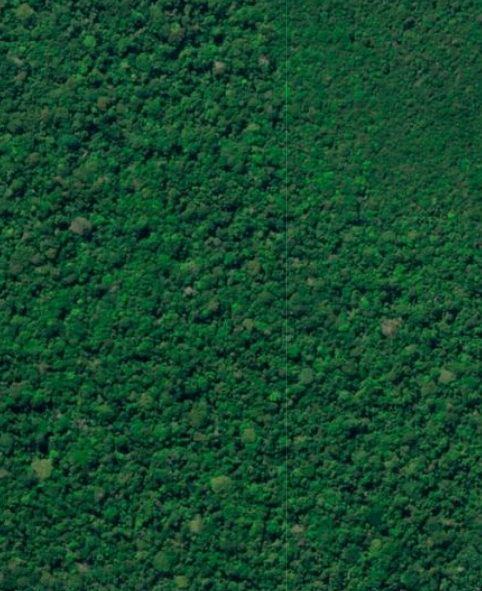

--------------------


In [137]:
uploaded = files.upload()

for fn in uploaded.keys():
    image_path = fn
    prediction, stored_path = predict_and_store(image_path)

    print(f"Image: {fn}")
    print(f"Prediction: {prediction}")
    if stored_path:
        print(f"Image stored at: {stored_path}")


        try:
            display(Image(image_path))
        except Exception as e:
            print(f"Error displaying image: {e}")

    print("-" * 20)